# Evaluation of Model and ECE/MCE

In [1]:
# Used code from https://github.com/preddy5/Residual-Learning-and-Stochastic-Depth as base
# coding: utf-8

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu1,floatX=float32,optimizer=None'
import numpy as np
import collections
import pickle

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import SGD
import keras.backend as K
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from keras.callbacks import (
    Callback,
    LearningRateScheduler,
)
from keras.layers import (
    Input,
    Activation,
    Add,
    Dense,
    Flatten,
    Lambda
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from resnet import (
    bn_relu_conv,
    conv_bn_relu,
    residual_block
)

Using TensorFlow backend.


In [2]:
def _bottleneck(input, nb_filters, init_subsample=(1, 1)):
    conv_1_1 = bn_relu_conv(input, nb_filters, 3, 3, W_regularizer=l2(weight_decay), subsample=init_subsample)
    conv_3_3 = bn_relu_conv(conv_1_1, nb_filters, 3, 3, W_regularizer=l2(weight_decay))
    return _shortcut(input, conv_3_3)

    
def _shortcut(input, residual):
    stride_width = input._keras_shape[2] // residual._keras_shape[2]
    stride_height = input._keras_shape[3] // residual._keras_shape[3]
    equal_channels = residual._keras_shape[1] == input._keras_shape[1]

    shortcut = input
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual._keras_shape[1], kernel_size=(1, 1), strides=(stride_width, stride_height),
                         kernel_initializer="he_normal", padding="valid",kernel_regularizer=l2(weight_decay),
                                 data_format="channels_first")(input)
        shortcut = Activation("relu")(shortcut)

    M1 = Add()([shortcut, residual])
    M1 = Activation("relu")(M1)
    
    gate = K.variable(0, dtype="int16")
    decay_rate = 1
    name = 'residual_'+str(len(gates)+1)
    gates[name]=[decay_rate, gate]
    return Lambda(lambda outputs: K.switch(gate, outputs[0], outputs[1]),
                  output_shape= lambda x: x[0], name=name)([shortcut, M1])


# http://arxiv.org/pdf/1512.03385v1.pdf
# 110 Layer resnet
    # repetations: = n*6 + 2 = 18*6 + 2 = 110
    # nr_classes: int - how many classes in the end
def resnet(n = 18, nr_classes=10):
    input = Input(shape=(img_channels, img_rows, img_cols))

    conv1 = conv_bn_relu(input, nb_filter=16, nb_row=3, nb_col=3, W_regularizer=l2(weight_decay))  # Filters, filter_size

    # Build residual blocks..
    block_fn = _bottleneck
    block1 = residual_block(conv1, block_fn, nb_filters=16, repetations=n, is_first_layer=True)
    block2 = residual_block(block1, block_fn, nb_filters=32, repetations=n)
    block3 = residual_block(block2, block_fn, nb_filters=64, repetations=n, subsample=True)
    
    # Classifier block
    pool2 = AveragePooling2D(pool_size=(8, 8))(block3)
    flatten1 = Flatten()(pool2)
    final = Dense(units=nr_classes, kernel_initializer="he_normal", activation="softmax", kernel_regularizer=l2(weight_decay))(flatten1)

    model = Model(inputs=input, outputs=final)
    return model



def set_decay_rate():
    for index, key in enumerate(gates):
        gates[key][0] = 1.0 - float(index)*pL / len(gates)

# Callbacks for updating gates and learning rate
def scheduler(epoch):

    if epoch < 2:
        return learning_rate*0.1
    elif epoch < nb_epochs/2:
        return learning_rate
    elif epoch < nb_epochs*3/4:
        return learning_rate*0.1
    return learning_rate*0.01


class Gates_Callback(Callback):
    def on_batch_begin(self, batch, logs={}):
        probs = np.random.uniform(size=len(gates))
        for i,j in zip(gates, probs):
            if j > gates[i][0]:
                K.set_value(gates[i][1], 1)
            else:
                K.set_value(gates[i][1], 0)

    def on_train_end(self, logs={}):
        for i in gates:
            K.set_value(gates[i][1],1)

In [3]:
# constants
learning_rate = 0.1
momentum = 0.9
img_rows, img_cols = 32, 32
img_channels = 3
nb_epochs = 500
batch_size = 128
nb_classes = 10
pL = 0.5
weight_decay = 1e-4
seed = 333


# data
(X_train, Y_train), (X_test, y_test) = cifar10.load_data()
X_train = np.transpose(X_train.astype('float32'), (0, 3, 1, 2))  # Channels first
X_test = np.transpose(X_test.astype('float32'), (0, 3, 1, 2))  # Channels first


# Data splitting (get additional 5k validation set)
# Sklearn to split
X_train45, x_val, Y_train45, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)  # random_state = seed

img_mean = X_train45.mean(axis=0)  # per-pixel mean
img_std = X_train45.std(axis=0)
X_train45 = (X_train45-img_mean)/img_std
x_val = (x_val-img_mean)/img_std
X_test = (X_test-img_mean)/img_std


img_gen = ImageDataGenerator(
    horizontal_flip=True,
    data_format="channels_first",
    width_shift_range=0.125,  # 0.125*32 = 4 so max padding of 4 pixels, as described in paper.
    height_shift_range=0.125,
    fill_mode="constant",
    cval = 0
)

img_gen.fit(X_train45)
Y_train45 = np_utils.to_categorical(Y_train45, nb_classes)  # 1-hot vector
y_val = np_utils.to_categorical(y_val, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
    

### Load in data and models

In [5]:
        
# building and training net
gates=collections.OrderedDict()
model = resnet(nr_classes=nb_classes)
#set_decay_rate()
sgd = SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss="categorical_crossentropy",metrics=["accuracy"])  

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
conv2d_113 (Conv2D)              (None, 16, 32, 32)    448         input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_110 (BatchNo (None, 16, 32, 32)    64          conv2d_113[0][0]                 
____________________________________________________________________________________________________
activation_167 (Activation)      (None, 16, 32, 32)    0           batch_normalization_110[0][0]    
___________________________________________________________________________________________

In [ ]:
    for i in gates:
        print(K.get_value(gates[i][1]), gates[i][0],i)

In [ ]:
# For evaluation should load model without gates?

print("Get test accuracy:")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

    

### Load in weights

In [7]:
weights_file = "model_weight_ep500_110SD_cifar_10.hdf5"
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.load_weights(weights_file, by_name=True)

### Get predictions

In [ ]:
y_probs = model.predict(x_test)
y_preds = np.argmax(y_probs, axis=1)
y_true = y_test

In [32]:
import sklearn.metrics as metrics
y_true = [ np.where(r==1)[0][0] for r in y_true]  # 1-hot vector back to numeric
accuracy = metrics.accuracy_score(y_true, y_preds) * 100
error = 100 - accuracy
print("Accuracy : ", accuracy)
print("Error : ", error)

Accuracy :  93.53
Error :  6.47


In [23]:
y_probs[4]

array([  2.86992291e-10,   8.84960549e-09,   1.25265984e-07,
         1.15543908e-09,   3.99131096e-07,   1.43384735e-10,
         9.99999523e-01,   8.47845665e-12,   2.13625606e-09,
         2.59910973e-08], dtype=float32)

In [33]:
y_confs = np.max(y_probs, axis=1)

In [34]:
y_confs[:5]

array([ 0.99999869,  0.99991214,  0.61590117,  0.99995363,  0.99999952], dtype=float32)

### Reliability diagrams

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns


def reliability_diagrams(predictions, truths, confidences, bin_size=0.1, n_boot=1000):

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)
    accs = []

    # Compute empirical probability for each bin
    plot_x = []
    for conf_thresh in upper_bounds:
        acc, perc_pred, avg_conf = compute_accuracy(conf_thresh-bin_size, conf_thresh, confidences, predictions, truths)
        plot_x.append(avg_conf)
        accs.append(acc)

    # Produce error bars for each bin
    upper_bound_to_bootstrap_est = {x:[] for x in upper_bounds}
    for i in range(n_boot):

        # Generate bootstrap
        boot_strap_outcomes = []
        boot_strap_confs = random.sample(confidences, len(confidences))
        for samp_conf in boot_strap_confs:
            correct = 0
            if random.random() < samp_conf:
                correct = 1
            boot_strap_outcomes.append(correct)

        # Compute error frequency in each bin
        for upper_bound in upper_bounds:
            conf_thresh_upper = upper_bound
            conf_thresh_lower = upper_bound - bin_size

            filtered_tuples = [x for x in zip(boot_strap_outcomes, boot_strap_confs) if x[1] > conf_thresh_lower and x[1] <= conf_thresh_upper]
            correct = len([x for x in filtered_tuples if x[0] == 1])
            acc = float(correct) / len(filtered_tuples) if len(filtered_tuples) > 0 else 0

            upper_bound_to_bootstrap_est[upper_bound].append(acc)
       
    upper_bound_to_bootstrap_upper_bar = {}
    upper_bound_to_bootstrap_lower_bar = {}
    for upper_bound, freqs in upper_bound_to_bootstrap_est.iteritems():
        top_95_quintile_i = int(0.975 * len(freqs))
        lower_5_quintile_i = int(0.025 * len(freqs))

        upper_bar = sorted(freqs)[top_95_quintile_i]
        lower_bar = sorted(freqs)[lower_5_quintile_i]

        upper_bound_to_bootstrap_upper_bar[upper_bound] = upper_bar
        upper_bound_to_bootstrap_lower_bar[upper_bound] = lower_bar

    upper_bars = []
    lower_bars = []
    for i, upper_bound in enumerate(upper_bounds):
        if upper_bound_to_bootstrap_upper_bar[upper_bound] == 0:
            upper_bars.append(0)
            lower_bars.append(0)
        else:
            # The error bar arguments need to be the distance from the data point, not the y-value
            upper_bars.append(abs(plot_x[i] - upper_bound_to_bootstrap_upper_bar[upper_bound]))
            lower_bars.append(abs(plot_x[i] - upper_bound_to_bootstrap_lower_bar[upper_bound]))

    #print zip(upper_bars, lower_bars)

    sns.set(font_scale=2)
    fig, ax = plt.subplots()
    ax.errorbar(plot_x, plot_x, yerr=[lower_bars, upper_bars], label="Perfect classifier calibration")

    new_plot_x = []
    new_accs = []
    for i, bars in enumerate(zip(lower_bars, upper_bars)):
        if bars[0] == 0 and bars[1] == 0:
            continue
        new_plot_x.append(plot_x[i])
        new_accs.append(accs[i])
    
    ax.plot(new_plot_x, new_accs, '-o', label="Accuracy", color="red")
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    sns.plt.ylabel('Empirical probability')
    sns.plt.xlabel('Estimated probability')

    fig.set_size_inches(5, 5)
    #fig.savefig("reliability.tif", format='tif', bbox_inches='tight', dpi=1200)
    #fig.savefig("reliability.eps", format='eps', bbox_inches='tight', dpi=1200)

    plt.show()
        


def compute_accuracy(conf_thresh_lower, conf_thresh_upper, conf, pred, true):

    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])
        avg_conf = sum([x[2] for x in filtered_tuples]) / len(filtered_tuples)
        accuracy = float(correct)/len(filtered_tuples)
        perc_of_data = float(len(filtered_tuples))/len(conf)
        return accuracy, perc_of_data, avg_conf

In [44]:
reliability_diagrams(predictions=y_preds, truths=y_true, confidences=y_confs, bin_size=0.1, n_boot=1000)

AttributeError: 'dict' object has no attribute 'iteritems'

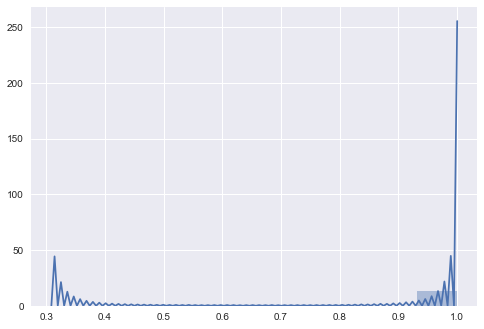

In [58]:
sns.distplot(y_confs, hist=True, bins=10)
plt.show()

In [51]:
accs

[0,
 0,
 0,
 0.14285714285714285,
 0.3,
 0.3894736842105263,
 0.5517241379310345,
 0.5242718446601942,
 0.5517241379310345,
 0.9595778364116095]

In [52]:
confs

[0,
 0,
 0,
 0.3550005682877132,
 0.4638959715763728,
 0.55478675114481069,
 0.64737404985674496,
 0.74964245256868378,
 0.8534404128447346,
 0.99738939514889879]

In [74]:
# Computes accuracy for bin

def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):

    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct)/len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin
    
def ECE(conf, pred, true, bin_size = 0.1):
    
    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins
    
    n = len(conf)
    ece = 0  # Starting error
    
    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, y_confs, y_preds, y_true)        
        ece += np.abs(acc-avg_conf)*len_bin/n  # Add weigthed difference to ECE
        
    return ece
        
    
def MCE(conf, pred, true, bin_size = 0.1):
    
    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)
    
    cal_errors = []
    
    for conf_thresh in upper_bounds:
        acc, avg_conf, _ = compute_acc_bin(conf_thresh-bin_size, conf_thresh, y_confs, y_preds, y_true)
        cal_errors.append(np.abs(acc-avg_conf))
        
    print(cal_errors)
        
    return max(cal_errors)

In [75]:
ECE(y_confs, y_preds, y_true)

0.046717833775281853

In [77]:
MCE(y_confs, y_preds, y_true)

[0, 0, 0, 0.21214342543057035, 0.16389597157637281, 0.16531306693428438, 0.095649911925710485, 0.22537060790848962, 0.30171627491370012, 0.037811558737289253]


0.30171627491370012

<table style="width:100%">
  <tr>
    <th>ResNet 110 CIFAR-10</th>
    <th>Paper</th>
    <th>Replicated</th> 
  </tr>
  <tr>
    <td>Test ERROR</td>
    <td>6.21%</td> 
    <td>6.47%</td>
  </tr>
  <tr>
    <td>ECE</td>
    <td>4.6%</td> 
    <td>4.67%</td>
  </tr>
  <tr>
    <td>MCE</td>
    <td>33.78%</td> 
    <td>30.17%</td>
  </tr>
</table>